In [1]:
import pandas as pd, numpy as np

In [2]:
from sklearn.preprocessing import LabelEncoder

In [3]:
df={}
df['tumor']=pd.read_pickle("updated_model_patch_annotations/tumor_annot.pkl")
df['macro']=pd.read_pickle("updated_model_patch_annotations/macro_annot.pkl")
df['tumor']['y_true']=LabelEncoder().fit_transform(df['tumor']['annotation'])
df['macro']['y_true']=LabelEncoder().fit_transform(df['macro']['annotation'])
df['macro'].loc[df['macro']['y_true']==4,'y_true']=-1

In [4]:
for k in df:
    df[k]['case']=df[k]['ID'].map(lambda x: x.split("_")[0])

In [5]:
from sklearn.model_selection import train_test_split
from skmultilearn.model_selection import iterative_train_test_split


In [13]:
# counts['macro'].sum(0)

subcutaneous tissue    100822.0
hole                     5751.0
dermis                 186175.0
epidermis               24434.0
dtype: float64

In [7]:
counts={}
for k in df:
    counts[k]=pd.concat([dff['annotation'].value_counts() for name,dff in df[k].groupby("ID")],axis=1).T.fillna(0.)
    print(counts[k])
    counts[k]['case']=np.vectorize(lambda x: x.split("_")[0])(df[k]['ID'].unique())
    counts[k].index=df[k]['ID'].unique()
    counts[k]=counts[k].groupby('case')[df[k]['annotation'].unique()].sum()
    if k=='macro': counts[k]=counts[k].drop(columns=['unassigned'])
    print(counts[k])

             benign     bcc  inflammation
annotation   4034.0  3132.0          22.0
annotation  10605.0  1803.0           0.0
annotation  10417.0  2966.0           0.0
annotation  13253.0  1822.0           0.0
annotation  19136.0   550.0         470.0
...             ...     ...           ...
annotation   8251.0   612.0          85.0
annotation   9578.0   359.0         102.0
annotation  13888.0   882.0         392.0
annotation  10857.0  2463.0         319.0
annotation  15687.0   936.0           0.0

[98 rows x 3 columns]
       benign      bcc  inflammation
case                                
100   26496.0   5065.0         885.0
102   16353.0    495.0         314.0
104   17968.0   3298.0         392.0
105   22879.0  12699.0         819.0
107   12775.0    813.0         834.0
...       ...      ...           ...
88    24330.0   2251.0         196.0
89    19846.0   1578.0        2012.0
9      5853.0   1775.0         233.0
95    15519.0   5274.0         413.0
97    18494.0   2367.0       

In [8]:
train_val_cases=dict()
for k in counts:
    np.random.seed(42)
    case_train, _, case_val, _ = iterative_train_test_split(counts[k].index.values.reshape(-1,1), (counts[k].apply(lambda x: x/x.sum(),axis=1)>counts[k].apply(lambda x: x/x.sum(),axis=1).median(0)).values, test_size = 0.3)
    print(len(case_train),len(case_val))
    train_val_cases[k]=dict(train=df[k].loc[df[k]['case'].isin(case_train.flatten())],val=df[k].loc[df[k]['case'].isin(case_val.flatten())])
    if k=="macro": 
        for k2 in train_val_cases[k]: 
            train_val_cases[k][k2]=train_val_cases[k][k2].loc[train_val_cases[k][k2]['annotation']!='unassigned']
#             train_val_cases[k][k2]=train_val_cases[k][k2].loc[~train_val_cases[k][k2]['ID'].isin(['15_A1a','108_A1d'])]

45 18
16 6


In [9]:
import pickle
pickle.dump(train_val_cases,open('updated_patches/train_val_patch_info.pkl','wb'))

In [10]:
import pickle
train_val_cases=pickle.load(open('updated_patches/train_val_patch_info.pkl','rb'))

In [11]:
for k in train_val_cases:
    np.random.seed(42)
    train_val_cases[k]['train']=pd.concat([dff.sample(min(dff.shape[0],30000)) for name,dff in train_val_cases[k]['train'].groupby(['annotation'])])#ID
    np.random.seed(42)
    train_val_cases[k]['val']=pd.concat([dff.sample(min(dff.shape[0],7000)) for name,dff in train_val_cases[k]['val'].groupby(['annotation'])])#ID
#     for k2 in train_val_cases[k]:
#         np.random.seed(42)
#         train_val_cases[k][k2]=pd.concat([dff.sample(min(dff.shape[0],2500)) for _,dff in train_val_cases[k][k2].groupby(['ID'])])#train_val_cases[k][k2].sort_values("ID").reset_index(drop=True)

In [15]:
# maybe increase this number
for k in train_val_cases:
    for k2 in train_val_cases[k]:
        print(train_val_cases[k][k2]['annotation'].value_counts())
        print(train_val_cases[k][k2]['ID'].nunique())

benign          30000
bcc             30000
inflammation    25123
Name: annotation, dtype: int64
71
benign          7000
bcc             7000
inflammation    7000
Name: annotation, dtype: int64
27
subcutaneous tissue    30000
dermis                 30000
epidermis              17875
hole                    3895
Name: annotation, dtype: int64
20
subcutaneous tissue    7000
dermis                 7000
epidermis              6559
hole                   1856
Name: annotation, dtype: int64
9


In [38]:
# can use above as train val cases for partitioning graph datasets

In [16]:
import tqdm
import os
import tifffile
from tifffile import TiffFile
def print2stack(X,name):
    print(name)
    return np.stack(X)
# https://github.com/Lyken17/Efficient-PyTorch
for k in tqdm.tqdm(list(train_val_cases.keys()),desc="macro_tumor"):
    for k2 in tqdm.tqdm(list(train_val_cases[k].keys()),desc="train_val"):
        if not os.path.exists(f'updated_patches/{k}/{k2}_data.pkl') or (k=='macro' and k2=='train'):
            X,y,names=[],[],[]
            for name, dff in tqdm.tqdm(train_val_cases[k][k2].groupby('ID'),total=train_val_cases[k][k2]['ID'].nunique(),desc="case"):
                if k=='macro': arr=tifffile.imread(f"new_skin_layers/Skin_Layer_ASAP_TIFF/{name}_ASAP.tif")#arr=np.load(f"inputs/{name}.npy")
                else: arr=tifffile.imread(f"new_test_slides/ASAP_Tiff/{name}_ASAP.tif")
    #                 with TiffFile(f"new_test_slides/ASAP_Tiff/{name}_ASAP.tif") as tif:
    #                     arr = tif.asarray(out='memmap')
    #                                 tifffile.imread(f"new_test_slides/ASAP_Tiff/{name}_ASAP.tif"))
#                 print(name)
#                 X.append(np.stack([arr[x:x+patch_size,y:y+patch_size] for x,y,patch_size in tqdm.tqdm(dff[['x','y','patch_size']].values.tolist(),desc='patch')]))
                names.append(name)
                print(name)
                X.append(np.stack([arr[x:x+patch_size,y:y+patch_size] for x,y,patch_size in tqdm.tqdm(dff[['x','y','patch_size']].values.tolist(),desc='patch')]))
                y.append(dff['y_true'].values.flatten())
                del arr
#             print([x.shape for x in X])
            X=np.concatenate(X,0)#[print2stack(x,name) for x,name in zip(X,names)],0)
            y=np.hstack(y)
            with open(f'updated_patches/{k}/{k2}_data.pkl','wb') as f:
                pickle.dump(dict(X=X,y=y,patch_info=train_val_cases[k][k2]),f,pickle.HIGHEST_PROTOCOL)
        # FINISH; dump patches to pickle file; make 4 pickle files and get training up and running; maybe view few images

train_val: 100%|██████████| 2/2 [00:00<00:00, 762.81it/s]

train_val:   0%|          | 0/2 [00:00<?, ?it/s]

case:   0%|          | 0/20 [00:00<?, ?it/s]


patch: 100%|██████████| 3421/3421 [00:00<00:00, 1029245.68it/s]

125_A2b





case:   5%|▌         | 1/20 [00:07<02:18,  7.28s/it]


patch: 100%|██████████| 1920/1920 [00:00<00:00, 480063.41it/s]


case:  10%|█         | 2/20 [00:11<01:52,  6.26s/it]

125_A2d





patch: 100%|██████████| 3236/3236 [00:00<00:00, 1186016.06it/s]

153_A1d





case:  15%|█▌        | 3/20 [00:18<01:53,  6.70s/it]


patch: 100%|██████████| 2404/2404 [00:00<00:00, 746454.46it/s]

15_A1a





case:  20%|██        | 4/20 [00:25<01:47,  6.75s/it]


patch: 100%|██████████| 3498/3498 [00:00<00:00, 1201709.84it/s]

20_B1d





case:  25%|██▌       | 5/20 [00:34<01:51,  7.43s/it]


patch: 100%|██████████| 3606/3606 [00:00<00:00, 530410.67it/s]

37_A1c





case:  30%|███       | 6/20 [00:41<01:42,  7.32s/it]


patch: 100%|██████████| 5638/5638 [00:00<00:00, 1241012.12it/s]

37_A2d





case:  35%|███▌      | 7/20 [00:49<01:36,  7.43s/it]


patch: 100%|██████████| 3654/3654 [00:00<00:00, 641576.81it/s]

37_A2eX





case:  40%|████      | 8/20 [00:56<01:28,  7.41s/it]


patch: 100%|██████████| 9796/9796 [00:00<00:00, 564969.43it/s]

41_A2b





case:  45%|████▌     | 9/20 [01:07<01:31,  8.30s/it]


patch: 100%|██████████| 6808/6808 [00:00<00:00, 572470.36it/s]

43_A2b





case:  50%|█████     | 10/20 [01:14<01:20,  8.03s/it]


patch: 100%|██████████| 3771/3771 [00:00<00:00, 1069058.49it/s]

44_A1c





case:  55%|█████▌    | 11/20 [01:21<01:07,  7.54s/it]


patch: 100%|██████████| 2489/2489 [00:00<00:00, 961822.61it/s]

47_A1c





case:  60%|██████    | 12/20 [01:26<00:55,  6.89s/it]


patch: 100%|██████████| 3057/3057 [00:00<00:00, 1193409.10it/s]

53_A1b





case:  65%|██████▌   | 13/20 [01:32<00:45,  6.51s/it]


patch: 100%|██████████| 5747/5747 [00:00<00:00, 1363617.42it/s]

60_A1c





case:  70%|███████   | 14/20 [01:40<00:42,  7.11s/it]


patch: 100%|██████████| 5076/5076 [00:00<00:00, 1289695.12it/s]

60_A1d





case:  75%|███████▌  | 15/20 [01:48<00:37,  7.40s/it]


patch: 100%|██████████| 4423/4423 [00:00<00:00, 1305517.71it/s]

66_A1b





case:  80%|████████  | 16/20 [01:54<00:27,  6.83s/it]


patch: 100%|██████████| 2065/2065 [00:00<00:00, 473059.03it/s]

78_A2d





case:  85%|████████▌ | 17/20 [01:56<00:16,  5.63s/it]


patch: 100%|██████████| 2462/2462 [00:00<00:00, 489610.57it/s]

85_A1b





case:  90%|█████████ | 18/20 [02:01<00:10,  5.30s/it]


patch: 100%|██████████| 4870/4870 [00:00<00:00, 1249771.20it/s]

90_A2b





case:  95%|█████████▌| 19/20 [02:10<00:06,  6.29s/it]


patch: 100%|██████████| 3829/3829 [00:00<00:00, 842204.10it/s]

9_A7b





case: 100%|██████████| 20/20 [02:19<00:00,  6.98s/it]

macro_tumor: 100%|██████████| 2/2 [03:51<00:00, 115.64s/it]


In [40]:
print(X.shape)

(21455, 256, 256, 3)


In [20]:
! mkdir -p updated_patches/tumor updated_patches/macro

In [ ]:
# evaluate input data
! ls patches/*/*.pkl
! ls inputs

In [4]:
val_data=pd.read_pickle("updated_patches/macro/val_data.pkl")

In [6]:
val_data['X'].shape

(2304, 256, 3)

In [17]:
df_anno=pd.read_pickle("updated_model_patch_annotations/macro_annot.pkl")
df_anno['ID'].unique()

array(['66_A1b', '36_B2e', '121_B1b', '60_A1c', '37_A2d', '20_B1c',
       '108_A1c', '5_A1eX', '85_A1b', '44_A1c', '5_A1d', '15_A1a',
       '153_A1d', '60_A1d', '3_A2c', '108_A1d', '125_A2b', '20_B1d',
       '9_A7b', '53_A1b', '91_A2b', '37_A1c', '47_A1c', '46_A2b',
       '37_A2eX', '41_A2b', '90_A2b', '78_A2d', '3_A2b'], dtype=object)

/dartfs-hpc/rc/home/w/f003k8w/.local/lib/python3.7/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Text(0.5, 1.0, '108_A1d')

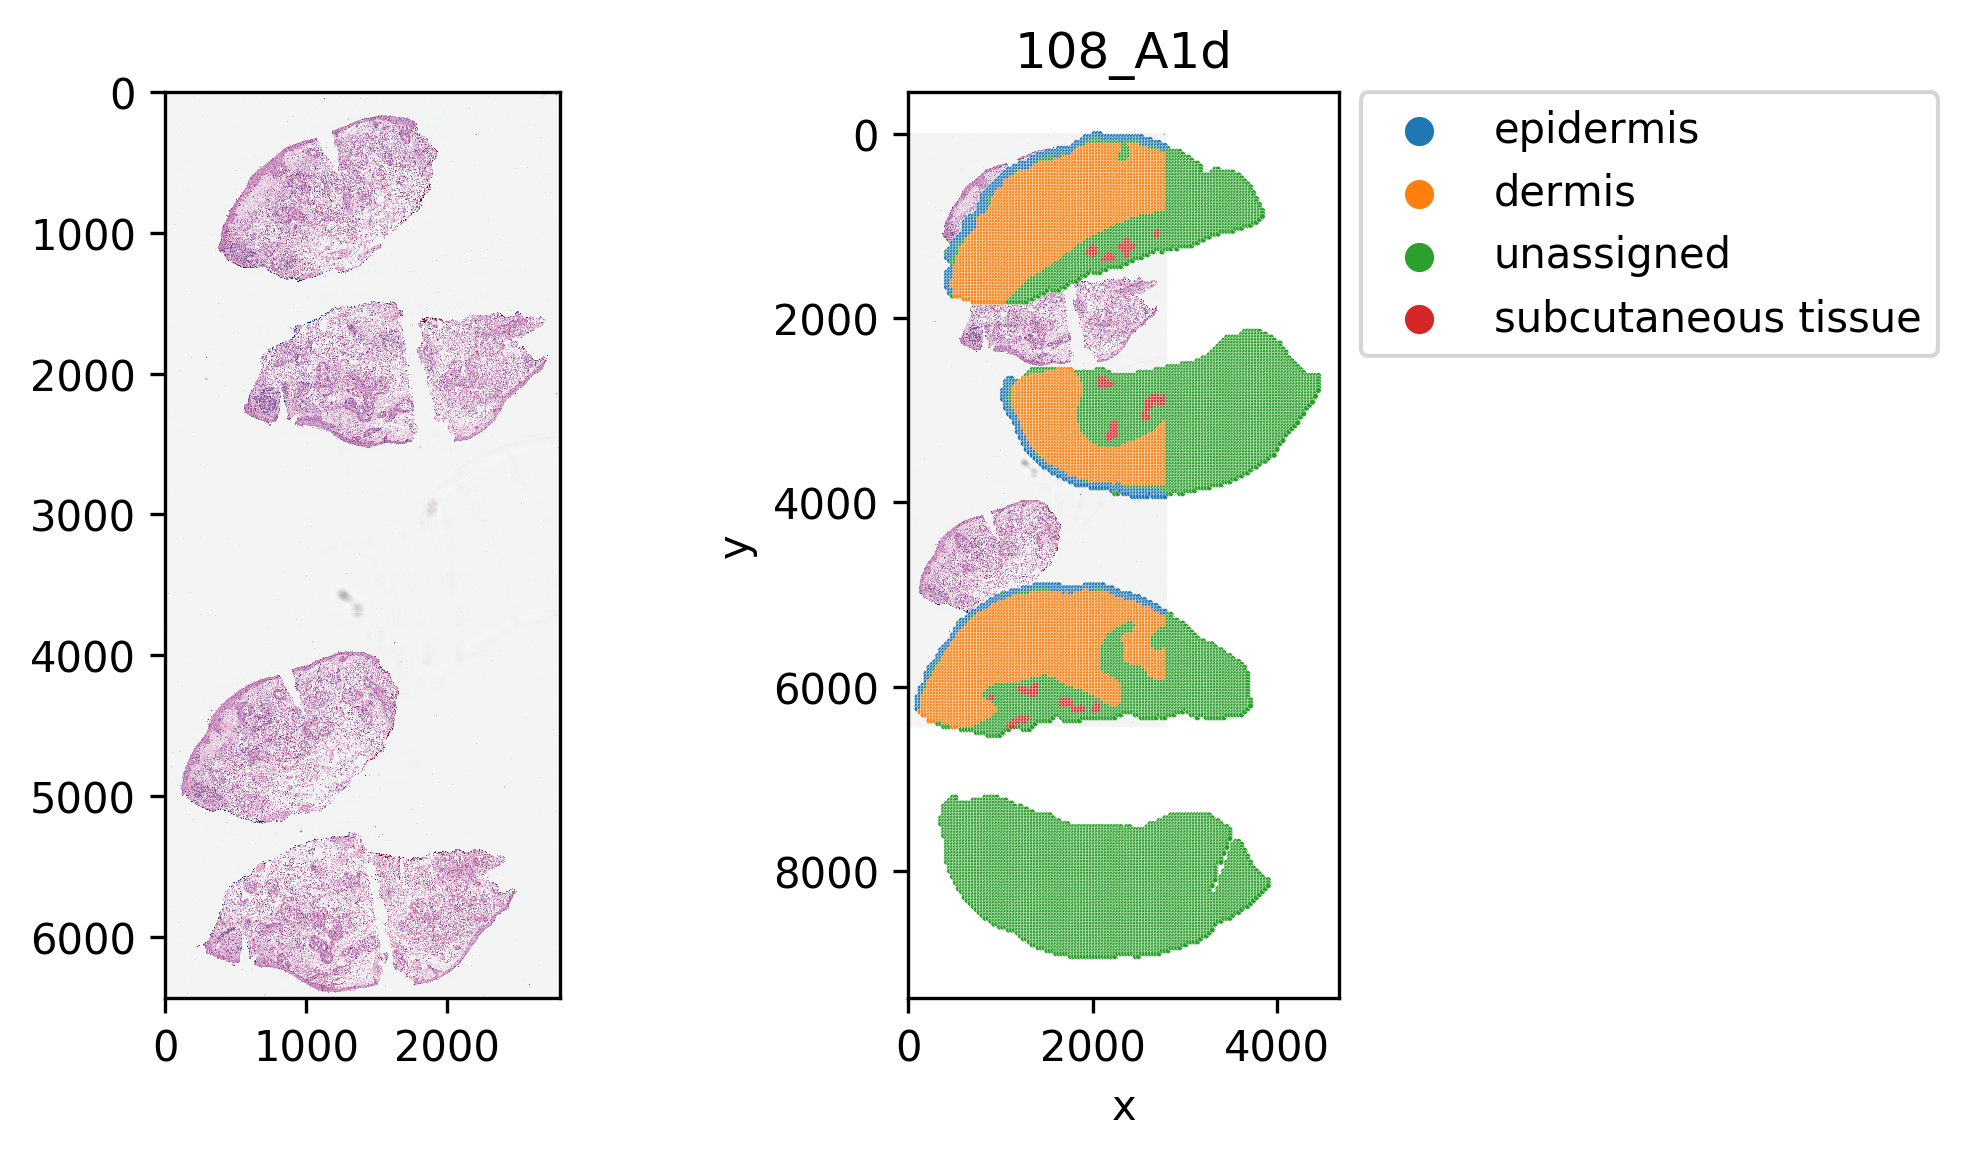

In [18]:
import cv2,tifffile
import seaborn as sns
import matplotlib, matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi']=300

k="108_A1d"
t='macro'
arr=cv2.resize(tifffile.imread(f"new_test_slides/ASAP_Tiff/{k}_ASAP.tif") if t!='macro' else np.load(f"inputs/{k}.npy"),None,fx=1/8,fy=1/8)#np.load(f"inputs/{k}.npy")

plt.subplot(121)
plt.imshow(np.transpose(arr,(1,0,2)))
plt.subplot(122)
plt.imshow(np.transpose(arr,(1,0,2)))
# for name,dff in val_data['patch_info'].groupby('ID'):#
dff=df_anno[df_anno['ID']==k]
# plt.figure()
dff[['x','y']]=dff[['y','x']].iloc[:,::-1]/8
sns.scatterplot(x='x',y='y',hue='annotation',data=dff,s=2.,alpha=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title(k)

In [ ]:
# break

In [ ]:
annots=np.hstack([annot for _,annot in val_data['patch_info'].groupby('ID')['annotation']])

In [ ]:
np.unique(annots)

In [ ]:
import matplotlib, matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi']=300
from skimage.io import imshow_collection
k='benign'
idx=np.where(annots==k)[0]
np.random.shuffle(idx)
fig=imshow_collection(val_data['X'][idx[:12]])
plt.suptitle(k)


In [ ]:
# evaluate output data

In [ ]:
val_data['patch_info']['ID'].unique()


In [2]:
import torch, pandas as pd, numpy as np
from sklearn.metrics import classification_report, roc_auc_score

In [5]:
k,k2='val','tumor'
preds=torch.load(f'pred_{k}_{k2}_tmp.pkl')
val_data=pd.read_pickle(f"updated_patches/{k2}/{k}_data.pkl")
annots=np.hstack([annot for _,annot in val_data['patch_info'].groupby('ID')['annotation']])
IDs=np.hstack([[name]*len(annot) for name,annot in val_data['patch_info'].groupby('ID')['annotation']])
lbl2annot=dict(zip(preds['true'],annots))

In [6]:
result_arr=pd.DataFrame(np.hstack([np.vstack([IDs,preds['true']]).T,preds['pred']]),columns=["ID","True"]+list(lbl2annot.values()))

In [14]:
from scipy.special import softmax#softmax(x.iloc[:,-3:].values.astype(float),1))#
pd.set_option('display.max_rows', len(IDs)+1)

pd.DataFrame(result_arr.groupby("ID").apply(lambda x:np.mean([roc_auc_score(x['True'].values.astype(int)==i,softmax(x.iloc[:,-3:].values.astype(float),1)[:,i]) for i in range(3) if sum(x['True'].values.astype(int)==i)]) if x['True'].nunique()>=2 else -1))

,0
ID,
105_A1b,0.878643
105_A1c,0.890074
105_A2c,0.942010
108_A1d,0.840953
117_A1a,0.901307
117_A1b,0.883589
117_A1c,0.859942
11_A1c,0.884171
120_A1a,0.875320


In [19]:
pd.DataFrame(result_arr.groupby("ID").apply(lambda x:np.mean([roc_auc_score(x['True'].values.astype(int)==i,softmax(x.iloc[:,-3:].values.astype(float),1)[:,i]) for i in range(3) if sum(x['True'].values.astype(int)==i)]) if x['True'].nunique()>=2 else -1)).sort_values([0]).iloc[2:].mean()

0    0.898515
dtype: float64

In [21]:
! ls updated* -lah

updated_checkpoints_cnn_macro:
total 638M
drwxrwx---  2 f003k8w rc-VaickusL_slow-admin 240 Jan 16 20:55 .
drwxrwx--- 21 f003k8w rc-VaickusL_slow-admin 12K Jan 16 20:30 ..
-rwxrwx---  1 f003k8w rc-VaickusL_slow-admin 91M Jan 16 19:47 0.epoch.checkpoint.pth
-rwxrwx---  1 f003k8w rc-VaickusL_slow-admin 91M Jan 16 19:54 1.epoch.checkpoint.pth
-rwxrwx---  1 f003k8w rc-VaickusL_slow-admin 91M Jan 16 20:09 3.epoch.checkpoint.pth
-rwxrwx---  1 f003k8w rc-VaickusL_slow-admin 91M Jan 16 20:40 7.epoch.checkpoint.pth
-rwxrwx---  1 f003k8w rc-VaickusL_slow-admin 91M Jan 16 20:47 8.epoch.checkpoint.pth
-rwxrwx---  1 f003k8w rc-VaickusL_slow-admin 91M Jan 16 20:55 9.epoch.checkpoint.pth

updated_checkpoints_cnn_tumor:
total 552M
drwxrwx---  2 f003k8w rc-VaickusL_slow-admin 202 Jan 16 19:23 .
drwxrwx--- 21 f003k8w rc-VaickusL_slow-admin 12K Jan 16 20:30 ..
-rwxrwx---  1 f003k8w rc-VaickusL_slow-admin 91M Jan 16 15:36 0.epoch.checkpoint.pth
-rwxrwx---  1 f003k8w rc-VaickusL_slow-admin 91M Jan 16 15:43 

In [3]:
from sklearn.metrics import f1_score
# pd.DataFrame(result_arr.groupby("ID").apply(lambda x:np.min([f1_score(x['True'].values.astype(int)==i,x.iloc[:,-3:].values.astype(float).argmax(1)==i) for i in range(3) if sum(x['True'].values.astype(int)==i)]) ) ).sort_values(by=[0])

In [10]:
lbl2annot

{0: 'bcc', 1: 'benign', 2: 'inflammation'}

In [11]:
print(classification_report(pd.Series(preds['true']).map(lbl2annot),pd.Series(preds['pred'].argmax(1)).map(lbl2annot)))
print("AUC",[roc_auc_score(preds['true']==i,preds['pred'][:,i]) for i in range(preds['pred'].shape[1])])
pd.crosstab(pd.Series(preds['true'],name='true').map(lbl2annot),pd.Series(preds['pred'].argmax(1),name='pred').map(lbl2annot))

              precision    recall  f1-score   support

         bcc       0.78      0.77      0.78      7000
      benign       0.81      0.71      0.75      7000
inflammation       0.70      0.79      0.74      7000

    accuracy                           0.76     21000
   macro avg       0.76      0.76      0.76     21000
weighted avg       0.76      0.76      0.76     21000

AUC [0.8987947806122449, 0.912581551020408, 0.8849507091836734]


pred,bcc,benign,inflammation
true,,,
bcc,5408,531,1061
benign,737,4948,1315
inflammation,783,662,5555


In [17]:
import torch
k,k2='val','macro'
preds=torch.load(f'pred_{k}_{k2}_tmp.pkl')
val_data=pd.read_pickle(f"patches/{k2}/{k}_data.pkl")

In [18]:
annots=np.hstack([annot for _,annot in val_data['patch_info'].groupby('ID')['annotation']])
IDs=np.hstack([[name]*len(annot) for name,annot in val_data['patch_info'].groupby('ID')['annotation']])

lbl2annot=dict(zip(preds['true'],annots))

In [19]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
lbl2annot=dict(zip(le.fit_transform(val_data['patch_info']['annotation'].value_counts().index),val_data['patch_info']['annotation'].value_counts().index))

In [20]:
print(classification_report(pd.Series(preds['true']).map(lbl2annot),pd.Series(preds['pred'].argmax(1)).map(lbl2annot)))
print("AUC",[roc_auc_score(preds['true']==i,preds['pred'][:,i]) for i in range(preds['pred'].shape[1])])
print("AUC",np.mean([roc_auc_score(preds['true']==i,preds['pred'][:,i]) for i in range(preds['pred'].shape[1])]))

pd.crosstab(pd.Series(preds['true'],name='true').map(lbl2annot),pd.Series(preds['pred'].argmax(1),name='pred').map(lbl2annot))

                     precision    recall  f1-score   support

             dermis       0.81      0.78      0.79      7000
          epidermis       0.87      0.87      0.87      6559
               hole       0.61      0.82      0.70      1856
subcutaneous tissue       0.84      0.79      0.81      7000

           accuracy                           0.81     22415
          macro avg       0.78      0.82      0.79     22415
       weighted avg       0.82      0.81      0.81     22415

AUC [0.9407441592141237, 0.9752317761053937, 0.9341996137902521, 0.9106155368147908]
AUC 0.94019777148114


pred,dermis,epidermis,hole,subcutaneous tissue
true,,,,
dermis,5440,479,150,931
epidermis,534,5706,296,23
hole,39,158,1530,129
subcutaneous tissue,717,184,547,5552


In [15]:
from scipy.special import softmax#softmax(x.iloc[:,-3:].values.astype(float),1))#
result_arr=pd.DataFrame(np.hstack([np.vstack([IDs,preds['true']]).T,preds['pred']]),columns=["ID","True"]+list(lbl2annot.values()))
result_arr.groupby("ID").apply(lambda x:np.min([roc_auc_score(x['True'].values.astype(int)==i,softmax(x.iloc[:,-4:].values.astype(float),1)[:,i]) for i in range(4) if sum(x['True'].values.astype(int)==i)]) if x['True'].nunique()>=2 else -1)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 22816 and the array at index 1 has size 22415

In [41]:
pd.DataFrame(result_arr.groupby("ID").apply(lambda x:np.min([f1_score(x['True'].values.astype(int)==i,x.iloc[:,-4:].values.astype(float).argmax(1)==i) for i in range(4) if sum(x['True'].values.astype(int)==i)]) ) ).sort_values(by=[0])

,0
ID,
60_A1d,0.516667
15_A1a,0.518053
91_A2b,0.518389
44_A1c,0.523601
47_A1c,0.531046
20_B1d,0.532024
5_A1eX,0.532435
3_A2c,0.533505
153_A1d,0.533526
